## 1. Постановка задачи

<center> <img src='../figures/taxi_meter.png' align="right" width="300"/> </center>
    
Вам предстоит решить настоящую задачу машинного обучения, направленную на автоматизацию бизнес процессов. Мы построим модель, которая будет предсказывать общую продолжительность поездки такси в Нью-Йорке. 

Представьте вы заказываете такси из одной точки Нью-Йорка в другую, причем не обязательно конечная точка должна находиться в пределах города. Сколько вы должны будете за нее заплатить? Известно, что стоимость такси в США  рассчитывается на основе фиксированной ставки + тарифная стоимость, величина которой зависит от времени и расстояния. Тарифы варьируются в зависимости от города.

В свою очередь время поездки зависит от множества факторов таких как, откуда и куда вы едете, в какое время суток вы совершаете вашу поездку, погодных условий и так далее. 

Таким образом, если мы разработаем алгоритм, способный определять длительность поездки, мы сможем прогнозировать ее стоимость самым тривиальным образом, например, просто умножая стоимость на заданный тариф. 
Сервисы такси хранят огромные объёмы информации о поездках, включая такие данные как конечная, начальная точка маршрута, дата поездки и ее длительность. Эти данные можно использовать для того, чтобы прогнозировать длительность поездки в автоматическом режиме с привлечением искусственного интеллекта.

**Бизнес-задача:** определить характеристики и с их помощью спрогнозировать длительность поездки такси.

**Техническая задача для вас как для специалиста в Data Science:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать числовой признак - время поездки такси. То есть решить задачу регрессии.

**Основные цели проекта:**
1. Сформировать набор данных на основе нескольких источников информации
2. Спроектировать новые признаки с помощью Feature Engineering и выявить наиболее значимые при построении модели
3. Исследовать предоставленные данные и выявить закономерности
4. Построить несколько моделей и выбрать из них наилучшую по заданной метрике
5. Спроектировать процесс предсказания времени длительности поездки для новых данных

Загрузить свое решение на платформу Kaggle, тем самым поучаствовав в настоящем Data Science соревновании.
Во время выполнения проекта вы отработаете навыки работы с несколькими источниками данных, генерации признаков, разведывательного анализа и визуализации данных, отбора признаков и, конечно же, построения моделей машинного обучения!


* id - a unique identifier for each trip
* vendor_id - a code indicating the provider associated with the trip record
* pickup_datetime - date and time when the meter was engaged
* dropoff_datetime - date and time when the meter was disengaged
* passenger_count - the number of passengers in the vehicle (driver entered value)
* pickup_longitude - the longitude where the meter was engaged
* pickup_latitude - the latitude where the meter was engaged
* dropoff_longitude - the longitude where the meter was disengaged
* dropoff_latitude - the latitude where the meter was disengaged
* store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* trip_duration - duration of the trip in seconds

## 2. Знакомство с данными, базовый анализ и расширение данных

Начнём наше исследование со знакомства с предоставленными данными. А также подгрузим дополнительные источники данных и расширим наш исходный датасет. 


Заранее импортируем модули, которые нам понадобятся для решения задачи:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import OneHotEncoder

In [2]:
import plotly.express as px
from zipfile import ZipFile
import os, sys
# Hides output while after model learned
from IPython.display import clear_output

# Display fixed length of a dataframe
pd.set_option("display.max_rows", 9, "display.max_columns", 9)

#set path
sys.path.insert(1, '../')

from utils.config_reader import config_reader
from utils.functions import read_csv_from_zip

# Import parameters
config = config_reader('../config/config.json')

random_seed = config.random_seed
path_figures = config.path_figures

> Загрузим данные и прочитаем в словарь все файы из архивов:

In [3]:
# # Создадим папку data, если такой папки нет
# if not os.path.exists("../data"):
#     os.mkdir("../data")
    
# import gdown
# url = "https://drive.google.com/drive/folders/" 
# output1 = '../data'
# gdown.download_folder(url, output=output1, quiet=True, use_cookies=False, remaining_ok=True)

mounts = read_csv_from_zip(path=config.data_dir, exclusion={'holiday_data.zip':';'})
mounts['osrm_data_train'] = mounts['osrm_data_train'][['id', 'total_distance', 'total_travel_time', 'number_of_steps']]
print('Прочитанные архивы: ', mounts.keys())
data = mounts['train'] #mounts.pop('train')

data.head(1)

Прочитанные архивы:  dict_keys(['holiday_data', 'Project5_osrm_data_test', 'osrm_data_train', 'Project5_test_data', 'train', 'weather_data'])


,id,vendor_id,pickup_datetime,dropoff_datetime,...,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,...,-73.96463,40.765602,N,455


In [5]:
print('Train data shape: {}'.format(data.shape))
data.info()

Train data shape: (1458644, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [6]:
data.describe().round(1).T

,count,mean,std,min,25%,50%,75%,max
vendor_id,1458644.0,1.5,0.5,1.0,1.0,2.0,2.0,2.0
passenger_count,1458644.0,1.7,1.3,0.0,1.0,1.0,2.0,9.0
pickup_longitude,1458644.0,-74.0,0.1,-121.9,-74.0,-74.0,-74.0,-61.3
pickup_latitude,1458644.0,40.8,0.0,34.4,40.7,40.8,40.8,51.9
dropoff_longitude,1458644.0,-74.0,0.1,-121.9,-74.0,-74.0,-74.0,-61.3
dropoff_latitude,1458644.0,40.8,0.0,32.2,40.7,40.8,40.8,43.9
trip_duration,1458644.0,959.5,5237.4,1.0,397.0,662.0,1075.0,3526282.0


Итак, у нас с вами есть данные о почти 1.5 миллионах поездок и 11 характеристиках, которые описывают каждую из поездок. 

Мы условно разделили признаки нескольких групп. Каждой из групп мы в дальнейшем уделим отдельное внимание.

**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах


Для начала мы проведем базовый анализ того, насколько данные готовы к дальнейшей предобработке и анализу. 

### Задание 2.1
Для начала посмотрим на временные рамки, в которых мы работаем с данными.

Переведите признак pickup_datetime в тип данных datetime с форматом год-месяц-день час:минута:секунда (в функции pd.to_datetime() параметр format='%Y-%m-%d %H:%M:%S'). 

Определите временные рамки (без учета времени), за которые представлены данные.

In [7]:
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'], errors='coerce'\
    , format='%Y-%m-%d %H:%M:%S') #, dayfirst=False
data['pickup_datetime'].head(1)

0   2016-03-14 17:24:55
Name: pickup_datetime, dtype: datetime64[ns]

### Задание 2.2
Посмотрим на пропуски. 
Сколько пропущенных значений присутствует в данных (суммарно по всем столбцам таблицы)?

In [8]:
data.isna().sum().sort_values(ascending=False)

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
                     ..
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
Length: 11, dtype: int64

### Задание 2.3
Посмотрим на статистические характеристики некоторых признаков. 

а) Сколько уникальных таксопарков присутствует в данных?

б) Каково максимальное количество пассажиров?

в) Чему равна средняя и медианная длительность поездки? Ответ приведите в секундах и округлите до целого.

г) Чему равно минимальное и максимальное время поездки (в секундах)?


In [9]:
print('Количество уникальных таксопарков: {}'.format(data['vendor_id'].nunique()))
print('Максимальное количество пассажиров: {}'.format(data['passenger_count'].max()))
print('Cредняя и медианная длительность поездки: {} +/- {} c. Медианное время {} c.'\
    .format(\
        data['trip_duration'].mean().round(), \
        data['trip_duration'].std().round(2), \
        data['trip_duration'].median().round()
    )
)
print('время поездки: минимальное {} с., максимальное: {} c.'\
    .format(data['trip_duration'].min().round(1), data['trip_duration'].max().round()))

Количество уникальных таксопарков: 2
Максимальное количество пассажиров: 9
Cредняя и медианная длительность поездки: 959.0 +/- 5237.43 c. Медианное время 662.0 c.
время поездки: минимальное 1 с., максимальное: 3526282 c.


Займемся расширением исходного набора данных как с помощью внешних источников, так и с помощью манипуляций над имеющимися в данных признаками. 


### Задание 2.4
Реализуйте функцию add_datetime_features(), которая принимает на вход таблицу с данными о поездках (DataFrame) и возвращает ту же таблицу с добавленными в нее 3 столбцами:
* pickup_date - дата включения счетчика - начала поездки (без времени);
* pickup_hour - час дня включения счетчика;
* pickup_day_of_week - наименование дня недели, в который был включен счетчик.

а) Сколько поездок было совершено в субботу?

б) Сколько поездок в среднем совершается в день? Ответ округлите до целого

In [10]:
def add_datetime_features(data:pd.DataFrame)->pd.DataFrame:
    """Добавляет 3 признака: дата включения счетчика - начала поездки (без времени),\
        час дня включения счетчика,  наименование дня недели, в который был включен счетчик

    Args:
        data (pd.DataFrame): _description_

    Returns:
        pd.DataFrame: _description_
    """    
    data['pickup_date'] = data['pickup_datetime'].dt.date
    data['pickup_hour'] = data['pickup_datetime'].dt.hour
    data['pickup_day_of_week'] = data['pickup_datetime'].dt.dayofweek 
    data['pickup_day_of_week'] = data['pickup_day_of_week'].astype('category').cat\
        .rename_categories({0:'Mon',1:'Tue',2:'wed', 3:'Thu',4:'Fri',5:'Sat',6:'Sun'}).astype('category')
        
    return data

data = add_datetime_features(data)
display(data.head(2))
print('Кол-во поездок в субботу: {}'.format(data[data['pickup_day_of_week']=='Sat']['id'].count()))
print('Среднее кол-во поездок в день: {}'.format(data.groupby(['pickup_date'])['id'].agg('count').mean().round()))

,id,vendor_id,pickup_datetime,dropoff_datetime,...,trip_duration,pickup_date,pickup_hour,pickup_day_of_week
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,...,455,2016-03-14,17,Mon
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,...,663,2016-06-12,0,Sun


Кол-во поездок в субботу: 220868
Среднее кол-во поездок в день: 8015.0


### Задание 2.5
Реализуйте функцию add_holiday_features(), которая принимает на вход две таблицы: 
* таблицу с данными о поездках;
* таблицу с данными о праздничных днях;

и возвращает обновленную таблицу с данными о поездках с добавленным в нее столбцом pickup_holiday - бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет). 

Чему равна медианная длительность поездки на такси в праздничные дни? Ответ приведите в секундах, округлив до целого.

In [11]:
def add_holiday_features(data:pd.DataFrame, holiday_data:pd.DataFrame)->pd.DataFrame:
    """ Добавляем признак совершения поездки в праздничный день (1 - да, 0 - нет). 

    Args:
        data (pd.DataFrame): датафрейм с даннными о поездках
        holidays (pd.DataFrame): массив с датами праздников США

    Returns:
        pd.DataFrame: массив даннных о поездках с признаком поездки в праздник
    """
    # даты праздников
    days_off = holiday_data['date'].values 
    
    # даты в строковый формат
    data['pickup_date_str'] = data['pickup_date'].apply(lambda x: x.strftime("%Y-%m-%d"))
    data['pickup_holiday'] = data['pickup_date_str'].apply(lambda x: 1 if x in days_off else 0)
    data.drop(['pickup_date_str'], axis=1, inplace=True)
             
    return data

data = add_holiday_features(data, mounts['holiday_data'])

print('Медианная длительность поездки на такси в праздничные дни : {} c.'.format\
    (data[data['pickup_holiday']==1]['trip_duration'].median().round()))

data.head(1)

Медианная длительность поездки на такси в праздничные дни : 585.0 c.


,id,vendor_id,pickup_datetime,dropoff_datetime,...,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,...,2016-03-14,17,Mon,0


### Задание 2.6
Реализуйте функцию add_osrm_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными из OSRM;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance;
* total_travel_time;
* number_of_steps.

а) Чему равна разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM? 

В результате объединения таблиц у вас должны были получиться пропуски в столбцах с информацией из OSRM API. Это связано с тем, что для некоторых поездок не удалось выгрузить данные из веб источника. 

б) Сколько пропусков содержится в столбцах с информацией из OSRM API после объединения таблиц?

In [12]:
osrm_data = mounts['osrm_data_train']  #pd.read_csv('data/osrm_data_train.csv')

def add_osrm_features(data:pd.DataFrame, osrm_data:pd.DataFrame)->pd.DataFrame:
    """ Объединяет 2 датафрейма. В результате добавляет к data признаки: 
            total_distance,  total_travel_time, number_of_steps.

    Args:
        data (pd.DataFrame): датафрейм с даннными о поездках
        osrm_data (pd.DataFrame): датафрейм с даннными о кратчайшем пути

    Returns:
        pd.DataFrame: объединённый датафрейм, в который добавлены признаки : \
            total_distance,  total_travel_time, number_of_steps.
    """    
    data = data.merge(osrm_data, how='left', on='id')
    return data

data = add_osrm_features(data, osrm_data)
display(data.head(1))
print('разница между медианными длительностями поездки в исходных данных \
    и полученной из OSRM : {} с.'.format(round(\
        data['trip_duration'].median() \
        - data['total_travel_time'].median())
    )
)

cols_null_percent = data.isna().sum()
cols_null = cols_null_percent[cols_null_percent > 0].sort_values(ascending=False)
display(cols_null)

,id,vendor_id,pickup_datetime,dropoff_datetime,...,pickup_holiday,total_distance,total_travel_time,number_of_steps
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,...,0,2009.1,164.9,5.0


разница между медианными длительностями поездки в исходных данных     и полученной из OSRM : 372 с.


total_distance       1
total_travel_time    1
number_of_steps      1
dtype: int64

In [13]:
display(data[data['total_distance'].isna()])

print('Кол-во уникальных строк с пропусками: {}'.format(\
    data[data['total_distance'].isna()].index.nunique()))

,id,vendor_id,pickup_datetime,dropoff_datetime,...,pickup_holiday,total_distance,total_travel_time,number_of_steps
1133561,id3008062,2,2016-06-23 19:04:09,2016-06-23 19:04:35,...,0,NaN,NaN,NaN


Кол-во уникальных строк с пропусками: 1


In [14]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # радиус земли в километрах
    EARTH_RADIUS = 6371 
    # считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h


def get_angle_direction(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

### Задание 2.7.
Реализуйте функцию add_geographical_features(), которая принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:
* haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.

Чему равно медианное расстояние Хаверсина поездок (в киллометрах)? Ответ округлите до сотых.


In [15]:
def add_geographical_features(data:pd.DataFrame)->pd.DataFrame:
    """Ддобавляет 2 признака в неё двумя столбцами:

    haversine_distance — расстояние Хаверсина между точками влючёния и выключения счетчика;
    direction — направление движения между точками влючёния и выключения счетчика;
    Args:
        data (pd.DataFrame): _description_

    Returns:
        pd.DataFrame: _description_
    """    
    data['haversine_distance'] = data.apply(lambda x: get_haversine_distance(\
        x['pickup_latitude'],  x['pickup_longitude'], \
        x['dropoff_latitude'], x['dropoff_longitude']), axis=1)
    
    data['direction'] = data.apply(lambda x: get_angle_direction(\
        x['pickup_latitude'],  x['pickup_longitude'], \
        x['dropoff_latitude'], x['dropoff_longitude']), axis=1)
                                                                                                                        
    return data

data = add_geographical_features(data)


print('медианное расстояние Хаверсина поездок  {} км.'.format(data['haversine_distance'].median().round(2)))

медианное расстояние Хаверсина поездок  2.09 км.


### Задание 2.8.
Реализуйте функцию add_cluster_features(), которая принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации. Функция должна возвращать обновленную таблицу с добавленными в нее столбцом geo_cluster - географический кластер, к которому относится поездка.

Сколько поездок содержится в наименьшем по размеру географическом кластере?


In [16]:
# создаем обучающую выборку из географических координат всех точек
coordinats = np.hstack((data[['pickup_latitude', 'pickup_longitude']],
                    data[['dropoff_latitude', 'dropoff_longitude']]))
# обучаем алгоритм кластеризации
kmeans = cluster.KMeans(n_clusters=10, random_state=random_seed)
kmeans.fit(coordinats)


# def add_cluster_features(data:pd.DataFrame, kmeans)->pd.DataFrame:
    
#     data['geo_cluster'] = kmeans.predict(coords)
#     return data

def add_cluster_features(data, cluster):
    coordinats = np.hstack((data[['pickup_latitude', 'pickup_longitude']], data[['dropoff_latitude', 'dropoff_longitude']]))

    data['geo_cluster'] = cluster.predict(coordinats)
    return data


data = add_cluster_features(data, kmeans)

print('В наименьшем по размеру географическом кластере содержится: {} прездки' \
    .format(data['geo_cluster'].value_counts().min()))

C:\Users\Lena\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


В наименьшем по размеру географическом кластере содержится: 2 прездки


### Задание 2.9.
Реализуйте функцию add_weather_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о погодных условиях на каждый час;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:
* temperature - температура;
* visibility - видимость;
* wind speed - средняя скорость ветра;
* precip - количество осадков;
* events - погодные явления.

а) Сколько поездок было совершено в снежную погоду?

В результате объединения у вас должны получиться записи, для которых в столбцах temperature, visibility, wind speed, precip, и events будут пропуски. Это связано с тем, что в таблице с данными о погодных условиях отсутствуют измерения для некоторых моментов времени, в которых включался счетчик поездки. 

б) Сколько процентов от общего количества наблюдений в таблице с данными о поездках занимают пропуски в столбцах с погодными условиями? Ответ приведите с точностью до сотых процента.


In [17]:
#weather_data = pd.read_csv('data/weather_data.csv')
weather_data = mounts['weather_data']
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8787 entries, 0 to 8786
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   time         8787 non-null   object 
 1   temperature  8787 non-null   float64
 2   windchill    2295 non-null   float64
 3   heat index   815 non-null    float64
 4   humidity     8787 non-null   float64
 5   pressure     8556 non-null   float64
 6   dew Point    8787 non-null   float64
 7   visibility   8787 non-null   float64
 8   wind dir     8787 non-null   object 
 9   wind speed   8787 non-null   float64
 10  gust speed   8787 non-null   float64
 11  precip       8787 non-null   float64
 12  events       8787 non-null   object 
 13  conditions   8787 non-null   object 
 14  date         8787 non-null   object 
 15  hour         8787 non-null   int64  
dtypes: float64(10), int64(1), object(5)
memory usage: 1.1+ MB


In [18]:
def add_weather_features(data:pd.DataFrame, weather)->pd.DataFrame:
    
    weather['time'] = pd.to_datetime(weather['time'])
    weather['date'] = weather['time'].dt.date
    weather['hour'] = weather['time'].dt.hour

    data = pd.merge(data, weather[[\
        'date', 'hour', 'temperature', 'visibility', 'wind speed', 'precip', 'events']],
        left_on=['pickup_date','pickup_hour'], right_on=['date', 'hour'], how='left')

    data = data.drop(columns=['date', 'hour'], axis=1)
 
    return data

data = add_weather_features(data, mounts['weather_data'])

print('Кол-во поездок в снежную погоду: {}'.format(data[data['events']=='Snow']['events'].count()))
print("Пропуски в признаке 'events'")
data['events'].isna().value_counts(True).round(4)

Кол-во поездок в снежную погоду: 13126
Пропуски в признаке 'events'


False    0.9918
True     0.0082
Name: events, dtype: float64

### Задание 2.10.
Реализуйте функцию fill_null_weather_data(), которая принимает на вход которая принимает на вход таблицу с данными о поездках. Функция должна заполнять пропущенные значения в столбцах.

Пропуски в столбцах с погодными условиями -  temperature, visibility, wind speed, precip заполните медианным значением температуры, влажности, скорости ветра и видимости в зависимости от даты начала поездки. Для этого сгруппируйте данные по столбцу pickup_date и рассчитайте медиану в каждой группе, после чего с помощью комбинации методов transform() и fillna() заполните пропуски. 
Пропуски в столбце events заполните строкой 'None' - символом отсутствия погодных явлений (снега/дождя/тумана). 

Пропуски в столбцах с информацией из OSRM API - total_distance, total_travel_time и number_of_steps заполните медианным значением по столбцам. 

Чему равна медиана в столбце temperature после заполнения пропусков? Ответ округлите до десятых.

In [19]:
def fill_null_weather_data(data:pd.DataFrame):
    for col in ['temperature', 'visibility', 'wind speed', 'precip']:
        data[col].fillna(data.groupby('pickup_date')[col].transform('median'), inplace=True)
    
    for col in ['total_distance', 'total_travel_time', 'number_of_steps']:
        data[col].fillna(data[col].median(), inplace=True)
        
    data['events'].fillna('None', inplace=True)
     
    return data

data = fill_null_weather_data(data)
print('Медианная температура: {} град.'.format(data['temperature'].median().round(1)))

data.isna().sum()

Медианная температура: 11.1 град.


id                  0
vendor_id           0
pickup_datetime     0
dropoff_datetime    0
                   ..
visibility          0
wind speed          0
precip              0
events              0
Length: 26, dtype: int64

В завершение первой части найдем очевидные выбросы в целевой переменной - длительности поездки. 

Проще всего найти слишком продолжительные поездки. Давайте условимся, что выбросами будут считаться поездки, длительность которых превышает 24 часа. 

Чуть сложнее с анализом поездок, длительность которых слишком мала. Потому что к ним относятся действительно реальные поездки на короткие расстояния, поездки, которые были отменены через секунду после того как включился счетчик, а также “телепортации” - перемещение на большие расстояния за считанные секунды. 
Условимся, что мы будем считать выбросами только последнюю группу. Как же нам их обнаружить наиболее простым способом?

Можно воспользоваться информацией о кратчайшем расстоянии, которое проезжает такси. Вычислить среднюю скорость автомобиля на кратчайшем пути следующим образом: 
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$
Если мы построим диаграмму рассеяния средней скорости движения автомобилей, мы увидим следующую картину:


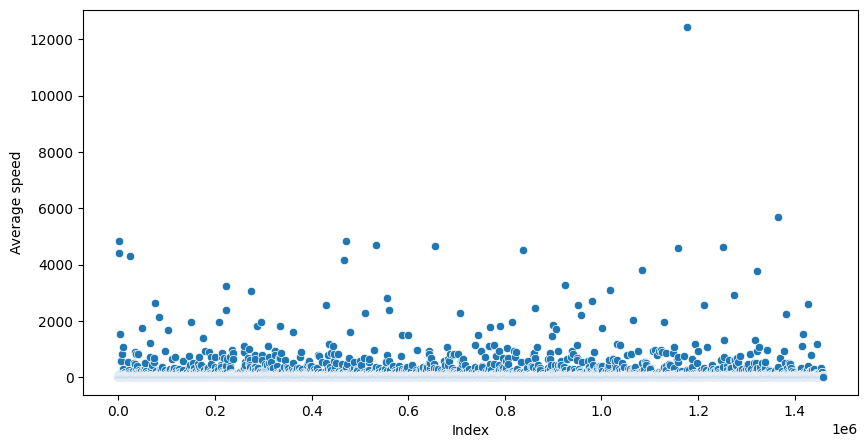

In [20]:
avg_speed = data['total_distance'] / data['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

Как раз отсюда мы видим, что у нас есть “поездки-телепортации”, для которых средняя скорость более 1000 км/ч. Даже есть такая, средняя скорость которой составляла более 12000 км/ч! 

Давайте условимся, что предельная средняя скорость, которую могут развивать таксисты будет 300 км/ч. 


### Задание 2.11.
Найдите поездки, длительность которых превышает 24 часа. И удалите их из набора данных.

а) Сколько выбросов по признаку длительности поездки вам удалось найти?

Найдите поездки, средняя скорость которых по кратчайшему пути превышает 300 км/ч и удалите их из данных. 

б) Сколько выбросов по признаку скорости вам удалось найти?

In [21]:
outliers_duration = data[data['trip_duration']>3600*24]
print('Кол-во выбросов по признаку длительности поездки: {}'.format(outliers_duration.shape[0]))

outliers_speed = data[(data['total_distance'] * 3.6/ data['trip_duration'] ) > 300]
print('Кол-во выбросов по признаку длительности поездки: {}'.format(outliers_speed.shape[0]))

data.drop(outliers_duration.index, axis=0, inplace=True)
data.drop(outliers_speed.index, axis=0, inplace=True)

Кол-во выбросов по признаку длительности поездки: 4
Кол-во выбросов по признаку длительности поездки: 407


## 3. Разведывательный анализ данных (EDA)

В этой части нашего проекта мы с вами:
* Исследуем сформированный набор данных; 
* Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении длительности поездки;
* Дополним наш анализ визуализациями, иллюстрирующими; исследование. Постарайтесь оформлять диаграммы с душой, а не «для галочки»: навыки визуализации полученных выводов обязательно пригодятся вам в будущем.


Начинаем с целевого признака. Забегая вперед, скажем, что основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:
$$trip\_duration\_log = log(trip\_duration+1),$$
где под символом log подразумевается натуральный логарифм.


In [22]:
data['trip_duration_log'] = np.log(data['trip_duration']+1)

### Задание 3.1.
Постройте гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе (trip_duration_log). 
Исходя из визуализации, сделайте предположение, является ли полученное распределение нормальным? 
Проверьте свою гипотезу с помощью теста Д’Агостино при уровне значимости $\alpha=0.05$. 

а) Чему равен вычисленный p-value? Ответ округлите до сотых.

б) Является ли распределение длительности поездок в логарифмическом масштабе нормальным?

In [23]:
# # построим гистограмму и коробчатую диаграмму на данных data:
# fig_1 = px.histogram(
#     data_frame=data, 
#     x='trip_duration_log',
#     opacity=0.5,  
#     marginal='box',
#     log_x=True,
#     nbins=30,
#     template="plotly_white"
#     )

# fig_1.update_layout(
#     #title=dict(text='Fig.1 - log trip duration distribution', x=.5, y=0.01, xanchor='center'),
#     title=dict(text='Рис.1 - Распределение логарифмической длительности поездки (trip_duration_log)', x=.5, y=0.01, xanchor='center'),
#     xaxis_title_text = 'Log trip duration',
#     yaxis_title_text = 'Trips',
#     width=800, height=400,
#     margin=dict(l=100, r=60, t=80, b=70),
#     showlegend=False  
# )
# #fig_1.write_image('figures/fig_1.png', engine="kaleido")

In [24]:
# from scipy import stats # библиотека для расчетов

# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
        
# sns.histplot(data, x= 'trip_duration_log', kde=True, bins=30, ax=ax[0]) # histogram
# ax[0].set_title('Histogram')
# stats.probplot(data['trip_duration_log'], plot=ax[1]); # qq plot
# #plt.suptitle('Fig.2 - Theoretical distribution', y=-0.05)
# plt.suptitle("Рис.2 - Сравнение распределения признака 'trip_duration_log' \n с нормальным", y=-0.05)
# plt.tight_layout();

# #fig.suptitle(f'Feature: {i} \n------------------', y=-0.05)

In [25]:
# H0 = 'Данные распределены нормально'
# Ha = 'Данные не распределены нормально (мы отвергаем H0)'

# _, p = stats.normaltest(data['trip_duration_log']) # Функция возвращает 2 значения: альфа и p-value

# print('P-value = {:.3f}'.format(p))

# alpha = 0.05
# check_Dagostino = lambda x: H0 if p > alpha else Ha
# print('p=',round(p, 3), check_Dagostino(p))

> На рис.2 изображена диаграмма распределения длительностей поездок в логарифмическом масштабе. Признак имеет логнормальное распределение. Cреднее значение совокупности составляет 6.5 +/- 0.8 лог.с. Признак содержит многочисленные выбросы за пределами  +/- 1.5 * межквартильный интервал.
> В целом распределение данных признака отличается от нормального. Аномалии сконцентрированы за границами +/- 1.5 * межквартильный интервал. Внутри интервала данные распределены  нормально. На это указывает результат теста Д'Агостино и совпадение линий на правом графике рис.2. 

### Задание 3.2.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от таксопарка (vendor_id). 

Сравните два распределения между собой.

In [26]:
# fig = plt.figure(figsize=(6, 3))

# fig = sns.boxplot(
#     data=data,
#     y='vendor_id',
#     x='trip_duration_log',
#     orient='h',
#     width=0.7
# )
# fig.set_title('Fig.3 - Trip duration by vendor_id', y=-0.5, fontsize=13)
# fig.set_title('Рис.3 - Зависимость длительности поездки от таксопарка', y=-0.5, fontsize=13)
# fig.set_xlabel('Trip duration, log sec.')
# fig.set_ylabel('Taxi park (vendor_id)')
# #plt.xlim(None, 5)
# fig.grid()
# plt.tight_layout();

# print('Анализ длительностей поездок таксопарков')
# data.groupby(['vendor_id'])['trip_duration_log'].agg(['count', 'mean','std']).round(2)

> На рис.3 изображено распределение длительности поездки по признаку таксопарка (vendor_id). Анализируя диаграмму отметим:
> * приблизительно равные средние длительности и стандартные отклонения времени поездки у обоих таксопарков 
> * аномально длительные поездки (выбросы) у машин таксопарка №2. Если все показания времени снимались точно, то выбросы могут быть обусловлены, например, пробками на дорогах.   

### Задание 3.3.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от признака отправки сообщения поставщику (store_and_fwd_flag). 

Сравните два распределения между собой.

In [27]:
# fig = plt.figure(figsize=(6, 3))

# fig = sns.boxplot(
#     data=data,
#     y='store_and_fwd_flag',
#     x='trip_duration_log',
#     orient='h',
#     width=0.7
# )
# fig.set_title('Fig.4 - Trip durations distribution storage in memory factor, log sec.', y=-0.5, fontsize=13)
# fig.set_title('Рис.4 - Зависимость длительности поездки от признака сохранения информации, log sec.', y=-0.5, fontsize=13)
# fig.set_xlabel('Trip duration, log sec.')
# fig.set_ylabel('store_and_fwd_flag')
# fig.grid()
# plt.tight_layout();

# print('Сравнение длительностей поездок с сохранением в памяти и без')
# #display(data['store_and_fwd_flag'].value_counts())
# display(data.groupby('store_and_fwd_flag')['trip_duration_log'].agg(['count','mean','std']).round(2))

> Анализируя диаграммы на рис.4 отметим, что размерности совокупностей существенно **отличаются**: поездки с сохранением данных составляют менее 1% всех случаев. Такие поездки с сохранением данных в среднем чуть дольше и с большим стандартным отклонением. С другой стороны, малое количество выбросов по верхней границе распределения указывает на повышенную точность измерений по сравнению с поездками без сохранения данных.

### Задание 3.4.
Постройте две визуализации:
* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.

На основе построенных графиков ответьте на следующие вопросы:

а) В какое время суток такси заказывают реже всего?

б) В какое время суток наблюдается пик медианной длительности поездок?

In [28]:
# temp = data.groupby(['pickup_hour'])['trip_duration'].median()

# fig, ax = plt.subplots( figsize=(10, 4)) #nrows=1, ncols=2 #,layout='constrained'

# fig = sns.countplot(
#     data, x= 'pickup_hour', color='C1', ax=ax, \
#     tick_label='Trip duration, hour', ) 
# ax.set_title('Trip duration by hours')

# ax2 = ax.twinx() 
# fig = sns.scatterplot(
#     temp, x=temp.index, y=temp.values, ax=ax2, marker='o', s=50,\
#     color='k', label='median trip duration')
# ax2.set_xlabel('Median trip duration, sec.')
# plt.legend(bbox_to_anchor=(1.4, 1))

# #plt.suptitle('Fig.4 - Trip duration by pickup hour', y=-0.05, fontsize=13)
# plt.suptitle('Рис.5 - Сравенение количества поездок с медианной длительностью по часам', y=-0.05, fontsize=13)
# plt.tight_layout();

> Анализируя диаграмму на рис.5 отметим следующее:
> * как и ожидалось, длительности поездок распределены во времени неравномероно: ночью(с 0 до 6 часов) совершается на 75% меньше поездок, чем в остальое время.
> * днем (в период с 11 до 16) совершаются более длительные поездки. Предположим, люди едут на деловые встречи по городу. 
> * c 17 до 20 часов люди чаще пользуются такси, но медианная длительность поездок постепенно убывает. Допустим, в это время совершаются поездки в рестораны либо в/из детских кружков.
> * c 21 до 23 часов медианная продолжительность поездок увеличивается. Это объясняется тем, что люди возвращаются домой из мест, где они отдыхали: из ресторанов, театров,.. и т.д.

### Задание 3.5.
Постройте две визуализации:
* Распределение количества поездок в зависимости от дня недели;
*  Зависимость медианной длительности поездки от дня недели.

На основе построенных графиков ответьте на следующие вопросы:
а) В какой день недели совершается больше всего поездок?
б) В какой день недели медианная длительность поездок наименьшая?


In [29]:
# temp = data.groupby(['pickup_day_of_week'])['trip_duration'].median()

# fig, ax = plt.subplots( figsize=(5, 3)) 

# fig = sns.countplot(
#     data, x= 'pickup_day_of_week', color='C1', ax=ax, \
#     tick_label='Trip duration, hour', ) 
# ax.set_title('Trip duration by week day')
# ax.set_ylim(150000,250000)

# ax2 = ax.twinx() 
# fig = sns.scatterplot(
#     temp, x=temp.index, y=temp.values, ax=ax2, marker='o', s=50,\
#     color='k', label='median trip duration')
# ax2.set_xlabel('Median trip duration, sec.')
# plt.legend(bbox_to_anchor=(1.7, 1))#loc='best'

# #plt.suptitle('Fig.6 - Trip duration by pickup hour', y=-0.05, fontsize=13)
# plt.suptitle('Рис.6 - Сравенение количества и медианных длительностей поездкок по дням недели', y=-0.05, fontsize=13);
# #plt.tight_layout();

> Анализируя диаграмму на рис.6 отметим, что наиболее продолжительные распределена неравномерно: с понедельника по четверг наблюдается равномерное увеличение медианной длительности поездок, а затем убывает. Количество поездок плавно растёт с понедельника по пятницу, а затем убывает.

### Задание 3.6.
Посмотрим на обе временные характеристики одновременно. 

Постройте сводную таблицу, по строкам которой отложены часы (pickup_hour), по столбцам - дни недели (pickup_day_of_week), а в ячейках - медианная длительность поездки (trip_duration). 

Визуализируйте полученную сводную таблицу с помощью тепловой карты (рекомендуемая палитра - coolwarm).

In [30]:
# pivot_table = data.pivot_table( #[data['price']>0]
#     values='trip_duration',
#     index='pickup_hour',
#     columns='pickup_day_of_week',
#     aggfunc='median'
# )
# fig,ax = plt.subplots(figsize=(8, 5))

# ax = sns.heatmap(
#     pivot_table, annot=True, fmt='1', cmap= 'coolwarm')
# ax.set_title('Рис. 7 - Медианная длительность поездки во времени', y=-0.25, fontsize=14);

> На рис.7 изображено распределение мендианной длительности поездки во времени. Характер распределение совпадает сожидаемым темпом городской жизни: активность в рабочие часы по рабочим дням и в вечение часы в субботу со спадами по ночам и в воскресенье. 
> Пик медианной длительности поездок смещается:
> * с понедельника по четверг он наблюдается с 8 до 18 часов. 
> * в четверг с 11 и 14 часов наблюдается абсолютный максимум
> * в пятницу интенсивность равномерно распределена с 8 утра до 1 часа ночи в субботу
> * Минимум поездок наблюдается в рабочие дни с 5 до 7 часов утра, а в выходные дни с 6 до 10 утра и в воскресенье с 18 часов

### Задание 3.7.
Постройте две диаграммы рассеяния (scatter-диаграммы):
* первая должна иллюстрировать географическое расположение точек начала поездок (pickup_longitude, pickup_latitude) 
* вторая должна географическое расположение точек завершения поездок (dropoff_longitude, dropoff_latitude).

Для этого на диаграммах по оси абсцисс отложите широту (longitude), а по оси ординат - долготу (latitude). 
Включите в визуализацию только те точки, которые находятся в пределах Нью-Йорка - добавьте следующие ограничения на границы осей абсцисс и ординат:
 
city_long_border = (-74.03, -73.75)

city_lat_border = (40.63, 40.85)

Добавьте на диаграммы расцветку по десяти географическим кластерам (geo_cluster), которые мы сгенерировали ранее. 

**Рекомендация:** для наглядности уменьшите размер точек на диаграмме рассеяния.

In [31]:
# city_long_border = (-74.03, -73.75)
# city_lat_border = (40.63, 40.85)

# fig, ax = plt.subplots(2,1, figsize=(10, 10))

# fig = sns.scatterplot(
#     data, x= 'pickup_longitude', y='pickup_latitude', ax=ax[0], s=0.5, hue='geo_cluster'
# ) 
# ax[0].set_title('pickup coordinates')
# ax[0].set_xlim(city_long_border)
# ax[0].set_ylim(city_lat_border)
  
# fig = sns.scatterplot(
#     data, x= 'dropoff_longitude', y='dropoff_latitude', ax=ax[1], s=0.5, hue='geo_cluster'
# )
# ax[1].set_title('Dropoff coordinates')
# ax[1].set_xlim(city_long_border)
# ax[1].set_ylim(city_lat_border)
# plt.legend()#bbox_to_anchor=(1.4, 1)

# # #plt.suptitle('Fig.8 - Passenger pickup and dropoff coordinates', y=-0.05, fontsize=13)
# plt.suptitle('Рис.8 - Координаты посадки и высадки пассажиров', y=-0.05, fontsize=13)
# plt.tight_layout();

> На рис. 8 усматриваются контуры Нью-Йорка

## 4. Отбор и преобразование признаков

Перед тем как перейти к построению модели, осталось сделать ещё несколько шагов.
* Следует помнить, что многие алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. Поэтому нам необходимо их закодировать;
* Надо отобрать признаки, которые мы будем использовать для обучения модели;
*  Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.


In [32]:
print('Shape of data: {}'.format(data.shape))
print('Columns: {}'.format(data.columns))

Shape of data: (1458233, 27)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'direction', 'geo_cluster',
       'temperature', 'visibility', 'wind speed', 'precip', 'events',
       'trip_duration_log'],
      dtype='object')


Для удобства работы сделаем копию исходной таблицы с поездками:

In [33]:
train_data = data.copy()
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,...,wind speed,precip,events,trip_duration_log
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,...,27.8,0.3,None,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,...,7.4,0.0,None,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,...,24.1,0.0,None,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,...,25.9,0.0,None,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,...,9.3,0.0,None,6.077642


### Задание 4.1.
Сразу позаботимся об очевидных неинформативных и избыточных признаках. 

а) Какой из признаков является уникальным для каждой поездки и не несет полезной информации в определении ее продолжительности?

б) Утечка данных (data leak) - это…

в) Подумайте, наличие какого из признаков в обучающем наборе данных создает утечку данных?

г) Исключите выбранные в пунктах а) и в) признаки из исходной таблицы с данными. Сколько столбцов в таблице у вас осталось?


In [34]:
train_data.drop(['id','dropoff_datetime'],axis=1, inplace=True)
train_data.shape

(1458233, 25)

Ранее мы извлекли всю необходимую для нас информацию из даты начала поездки, теперь мы можем избавиться от этих признаков, так как они нам больше не понадобятся:


In [35]:
drop_columns = ['pickup_datetime', 'pickup_date']
train_data = train_data.drop(drop_columns, axis=1)
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458233, 23)


### Задание 4.2.
Закодируйте признак vendor_id в таблице train_data таким образом, чтобы он был равен 1, если идентификатор таксопарка равен 0, и 1 в противном случае.

Закодируйте признак store_and_fwd_flag в таблице train_data таким образом, чтобы он был равен 0, если флаг выставлен в значение "N", и 0 в противном случае.

а) Рассчитайте среднее по закодированному столбцу vendor_id. Ответ приведите с точностью до сотых.

б) Рассчитайте среднее по закодированному столбцу store_and_fwd_flag. Ответ приведите с точностью до тысячных.

In [36]:
train_data['vendor_id'] = train_data['vendor_id'].apply(lambda x: 0 if x==1 else 1)
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].apply(lambda x: 0 if x=='N' else 1)

print("Cреднее для 'vendor_id': {}".format(train_data['vendor_id'].mean().round(2)))
print("Cреднее для 'store_and_fwd_flag': {}".format(train_data['store_and_fwd_flag'].mean().round(3)))

Cреднее для 'vendor_id': 0.53
Cреднее для 'store_and_fwd_flag': 0.006


### Задание 4.3.
Создайте таблицу data_onehot из закодированных однократным кодированием признаков pickup_day_of_week, geo_cluster и events в таблице train_data с помощью OneHotEndoder из библиотеки sklearn. Параметр drop выставите в значение 'first', чтобы удалять первый бинарный столбец, тем самым не создавая излишних признаков.

В результате работы OneHotEncoder вы получите безымянный numpy-массив, который нам будет необходимо преобразовать обратно в DataFrame, для более удобной работы в дальнейшем. Чтобы получить имена закодированных столбцов у объекта типа OneHotEncoder есть специальный метод get_feature_names_out(). Он возвращает список новых закодированных имен столбцов в формате <оригинальное имя столбца>_<имя категории>.

Пример использования:

``` python
# Получаем закодированные имена столбцов
column_names = one_hot_encoder.get_feature_names_out()
# Составляем DataFrame из закодированных признаков
data_onehot = pd.DataFrame(data_onehot, columns=column_names)
```

В этом псевдокоде:
* one_hot_encoder - объект класса OneHotEncoder
* data_onehot - numpy-массив, полученный в результате трансформации кодировщиком

В результате выполнения задания у вас должен быть образован DataFrame `data_onehot`, который содержит кодированные категориальные признаки pickup_day_of_week, geo_cluster и events. 


Сколько бинарных столбцов у вас получилось сгенерировать с помощью однократного кодирования?


In [37]:
columns_to_change=['pickup_day_of_week', 'geo_cluster', 'events']
one_hot_encoder = OneHotEncoder(drop='first') 

data_onehot = train_data[columns_to_change]
data_onehot = one_hot_encoder.fit_transform(data_onehot)
# Получаем закодированные имена столбцов
columns_names = one_hot_encoder.get_feature_names_out()

# Составляем DataFrame из закодированных признаков
data_onehot = pd.DataFrame(data_onehot.toarray(), columns=columns_names)

print('Кол-во бинарных столбцов после кодирования', data_onehot.shape[1])

Кол-во бинарных столбцов после кодирования 18


Добавим полученную таблицу с закодированными признаками:

In [38]:
train_data = pd.concat([train_data.reset_index(drop=True).drop(columns_to_change, axis=1), data_onehot], 
    axis=1
)
print('Shape of data: {}'.format(train_data.shape))

Shape of data: (1458233, 38)


Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log:


In [39]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

Все наши модели мы будем обучать на логарифмированной версии y_log. 

Выбранный тип валидации - hold-out. Разобьем выборку на обучающую и валидационную в соотношении 67/33:

In [40]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log, 
    test_size=0.33, 
    random_state=42
)

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.


### Задание 4.4.
С помощью SelectKBest отберите 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе. Отбор реализуйте по обучающей выборке, используя параметр score_func = f_regression.

Укажите признаки, которые вошли в список отобранных


In [41]:
selector = SelectKBest(score_func=f_regression, k=25)
selector.fit(X_train, y_train_log)
best_features = selector.get_feature_names_out()

X_best_train = selector.transform(X_train)
X_best_train = pd.DataFrame(X_best_train, columns=selector.get_feature_names_out())

X_best_valid = selector.transform(X_valid)

X_best_valid = pd.DataFrame(X_best_valid, columns=selector.get_feature_names_out())
print(best_features)

['vendor_id' 'passenger_count' 'pickup_longitude' 'pickup_latitude'
 'dropoff_longitude' 'dropoff_latitude' 'store_and_fwd_flag' 'pickup_hour'
 'pickup_holiday' 'total_distance' 'total_travel_time' 'number_of_steps'
 'haversine_distance' 'temperature' 'pickup_day_of_week_Mon'
 'pickup_day_of_week_Sat' 'pickup_day_of_week_Sun'
 'pickup_day_of_week_Thu' 'pickup_day_of_week_Tue'
 'pickup_day_of_week_wed' 'geo_cluster_1' 'geo_cluster_3' 'geo_cluster_5'
 'geo_cluster_7' 'geo_cluster_9']


Так как мы будем использовать различные модели, в том числе внутри которых заложены численные методы оптимизации, то давайте заранее позаботимся о масштабировании факторов. 


### Задание 4.5.
Нормализуйте предикторы в обучающей и валидационной выборках с помощью MinMaxScaler из библиотеки sklearn. Помните, что обучение нормализатора производится на обучающей выборке, а трансформация на обучающей и валидационной!

Рассчитайте среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из валидационной выборки. Ответ округлите до сотых.


In [42]:
from sklearn.preprocessing import MinMaxScaler 
# Scaling values
scaler = MinMaxScaler(feature_range=(0, 1))
X_train, X_valid = scaler.fit_transform(X_best_train), scaler.transform(X_best_valid)
print('среднее арифметическое для первого столбца валидационной выборки:', np.round(np.mean(X_valid[:,0]),2))

среднее арифметическое для первого столбца валидационной выборки: 0.54


## 5. Решение задачи регрессии: линейная регрессия и деревья решений

Определим метрику, по которой мы будем измерять качество наших моделей. Мы будем следовать канонам исходного соревнования на Kaggle и в качестве метрики использовать RMSLE (Root Mean Squared Log Error), которая вычисляется как:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
где:
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Заметим, что логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе:
$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$ 



### Задание 5.1.
Постройте модель линейной регрессии на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
# Creation an instance
lin = LinearRegression()

# Train the Model
lin.fit(X_train, y_train_log) #X_train, X_valid, y_train_log, y_valid_log

# Predict target values
y_pred_train, y_pred_valid = lin.predict(X_train), lin.predict(X_valid)

print('RMSLR train {:.2f}'.format(np.sqrt(mean_squared_error(y_train_log, y_pred_train))))
print('RMSLR valid {:.2f}'.format(np.sqrt(mean_squared_error(y_valid_log, y_pred_valid))))

RMSLR train 0.54
RMSLR valid 0.54


### Задание 5.2.
Сгенерируйте полиномиальные признаки 2-ой степени с помощью PolynomialFeatures из библиотеки sklearn. Параметр include_bias выставите в значение False.

Постройте модель полиномиальной регрессии 2-ой степени на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [44]:
from sklearn.preprocessing import PolynomialFeatures

# генератор полиномиальных признаков
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_best_train)

# добавление полиномиальных признаков
X_train_poly = poly.transform(X_train)
X_valid_poly = poly.transform(X_valid)

lr_poly = linear_model.LinearRegression()
lr_poly.fit(X_train_poly, y_train_log)

#предсказание
y_pred_train, y_pred_valid = lr_poly.predict(X_train_poly), lr_poly.predict(X_valid_poly)

print('Для модели полиномиальной регрессии:')
print('RMSLR train: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_pred_train))))
print('RMSLR valid: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_pred_valid))))

C:\Users\Lena\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
C:\Users\Lena\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


Для модели полиномиальной регрессии:
RMSLR train: 0.47
RMSLR valid: 0.70


### Задание 5.3.
Постройте модель полиномиальной регрессии 2-ой степени с L2-регуляризацией (регуляризация по Тихонову) на обучающей выборке  (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Коэффициент регуляризации $\alpha установите равным 1, остальные параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [45]:
# # объект класса линейной регрессии с L2-регуляризацией
# ridge_poly = linear_model.Ridge(alpha=1)
# ridge_poly.fit(X_train_poly, y_train_log)

# #предсказание
# y_pred_train, y_pred_valid = ridge_poly.predict(X_train_poly), ridge_poly.predict(X_valid_poly)

# print('RMSLR train c L2-регуляризацией: {:.2f}'.format(np.sqrt(mean_squared_error(y_train_log, y_pred_train))))
# print('RMSLR valid c L2-регуляризацией: {:.2f}'.format(np.sqrt(mean_squared_error(y_valid_log, y_pred_valid))))

### Задание 5.4.
Постройте модель дерева решений (DecisionTreeRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию. 

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [46]:
# from sklearn.tree import DecisionTreeRegressor

# dt = DecisionTreeRegressor(random_state=42)
# dt.fit(X_train, y_train_log)

# # предсказание
# y_pred_train, y_pred_valid = dt.predict(X_train), dt.predict(X_valid)

# print('RMSLR train c DecisionTree: {:.2f}'.format(np.sqrt(mean_squared_error(y_train_log, y_pred_train))))
# print('RMSLR valid c DecisionTree: {:.2f}'.format(np.sqrt(mean_squared_error(y_valid_log, y_pred_valid))))

### Задание 5.5.
Переберите все возможные варианты глубины дерева решений в диапазоне от 7 до 20:

max_depths = range(7, 20)

Постройте линейные графики изменения метрики RMSE на тренировочной и валидационной выборках в зависимости от значения параметра глубины дерева решений. 

а) Найдите оптимальное значение максимальной глубины дерева, для которой будет наблюдаться минимальное значение RMSLE на обучающей выборке, но при этом еще не будет наблюдаться переобучение (валидационная кривая еще не начинает возрастать).

б) Чему равно значение метрик RMSLE на тренировочной и валидационной выборках для дерева решений с выбранной оптимальной глубиной? Ответ округлите до сотых.


In [47]:
# max_depths = range(7, 20)
# metrics = dict()

# for i in max_depths:
#     dt = DecisionTreeRegressor(max_depth=i, random_state=42)
#     dt.fit(X_train, y_train_log)

#     # предсказание
#     y_pred_train, y_pred_valid = dt.predict(X_train), dt.predict(X_valid)

#     metrics[i] = [\
#         np.sqrt(mean_squared_error(y_train_log, y_pred_train)),
#         np.sqrt(mean_squared_error(y_valid_log, y_pred_valid))
# ]
# temp = np.array(list(metrics.values()))

# idx = np.argmin(temp[:,0])
# print('Оптимальные метрики Train {:.2f} и Valid {:.2f}'.format(temp[idx-7][0], temp[idx-7][1]))

In [48]:
# fig = plt.figure(figsize=(6, 3))
# fig = sns.lineplot(x=max_depths, y=temp[:,0], label='Train')
# fig = sns.lineplot(x=max_depths, y=temp[:,1], label='Valid')
# plt.plot(idx,temp[idx-7][1], 'ro') 

# fig.set_title('Рис.9 - Зависимость ошибки от глубины дерева', y=-0.5, fontsize=13)
# fig.set_xlabel('Метрика трейна')
# fig.set_ylabel('Метрика')
# plt.xticks(max_depths)
# fig.grid()
# plt.tight_layout();

## 6. Решение задачи регрессии: ансамблевые методы и построение прогноза

Переходим к тяжелой артиллерии: ансамблевым алгоритмам. 

### Задание 6.1.

Постройте модель случайного леса на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* n_estimators=200,
* max_depth=12,
* criterion='squared_error',
* min_samples_split=20,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [49]:
# from sklearn.ensemble import RandomForestRegressor 

# # Create the model
# model = RandomForestRegressor(n_estimators=200, 
#     max_depth=12, 
#     criterion='squared_error',    
#     min_samples_split=20,
#     random_state=42, verbose=0, n_jobs=-1)
# # Learn the model
# model.fit(X_train, y_train_log)

# # предсказание
# y_pred_train, y_pred_valid = model.predict(X_train), model.predict(X_valid)

# print('RMSLR train c RandomForest: {:.2f}'.format(np.sqrt(mean_squared_error(y_train_log, y_pred_train))))
# print('RMSLR valid c RandomForest: {:.2f}'.format(np.sqrt(mean_squared_error(y_valid_log, y_pred_valid))))

### Задание 6.2.
Постройте модель градиентного бустинга над деревьями решений (GradientBoostingRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* learning_rate=0.5,
* n_estimators=100,
* max_depth=6, 
* min_samples_split=30,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [75]:
from sklearn.ensemble import GradientBoostingRegressor

# Create the model
model = GradientBoostingRegressor(
    learning_rate=0.5,
    n_estimators=100,max_depth=6, min_samples_split=30,
    random_state=42, verbose=0)

# Learn the model
model.fit(X_train, y_train_log)

# предсказание
y_pred_train, y_pred_valid = model.predict(X_train), model.predict(X_valid)

print('RMSLR train c GradientBoosting: {:.2f}'.format(np.sqrt(mean_squared_error(y_train_log, y_pred_train))))
print('RMSLR valid c GradientBoosting: {:.2f}'.format(np.sqrt(mean_squared_error(y_valid_log, y_pred_valid))))

RMSLR train c GradientBoosting: 0.37
RMSLR valid c GradientBoosting: 0.39


### Задание 6.3.
Какая из построенных вами моделей показала наилучший результат (наименьшее значение RMSLE на валидационной выборке)?
* Линейная регрессия
* Полиномиальная регрессия 2ой степени
* Дерево решений
* Случайный лес
* Градиентный бустинг над деревьями решений


### Задание 6.4.
Постройте столбчатую диаграмму коэффициентов значимости каждого из факторов.

Укажите топ-3 наиболее значимых для предсказания целевого признака - длительности поездки в логарифмическом масштабе - факторов.


In [51]:
# arrays names and values
f_keys, f_values = best_features, model.feature_importances_
# sort and reverse arrays
idx   = np.argsort(f_values)[::-1]

f_keys, f_values = np.array(f_keys)[idx], np.array(f_values)[idx]

# Table
factors = pd.DataFrame({'factor':f_keys,
              'value':f_values
}).sort_values(by='value', ascending=False).head(5)

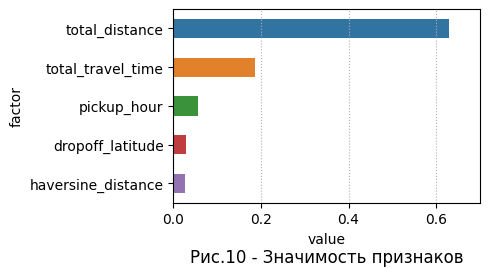

In [52]:
fig_id=10

# display a bar chart
fig, ax = plt.subplots(figsize=(5, 3))
sns.barplot(factors, x='value', y='factor', width=0.5)
#ax.grid()
#ax.set_title(f'Fig.{fig_id} - feature significance', y=-0.35); 
ax.set_title(f'Рис.{fig_id} - Значимость признаков', y=-0.35); 
plt.tight_layout()
major_ticks = np.linspace(0, 0.6, 4)
ax.set_xticks(major_ticks)
ax.set_xlim(0,0.7)
ax.xaxis.grid(linestyle=':');

#plt.savefig(os.path.join(path_figures, f'fig_{fig_id}.png'))

### Задание 6.5.
Для лучшей из построенных моделей рассчитайте медианную абсолютную ошибку (MeAE - в sklearn функция median_absolute_error) предсказания длительности поездки такси на валидационной выборке:
$$ MeAE = median(|y_i-\hat{y_i}|)$$

Значение метрики MeAE переведите в минуты и округлите до десятых.


In [53]:
from sklearn.metrics import median_absolute_error

y_valid, y_pred = np.exp(y_valid_log) - 1, np.exp(y_pred_valid) - 1

print('MAE valid для GradientBoosting: {:.1f}'.format(median_absolute_error(y_valid, y_pred)/60))

MAE valid для GradientBoosting: 1.8


Финальный шаг - сделать submit -  предсказание для отложенного тестового набора данных. 

Прочитаем тестовые данные и заранее выделим столбец с идентификаторами поездок из тестового набора данных. Он нам еще пригодится:


In [76]:
test_data = mounts['Project5_test_data'] #mounts.pop('test_data')
test_id = test_data['id']

holiday_data = mounts['holiday_data'] #mounts.pop('holiday_data')
osrm_data_test = mounts['Project5_osrm_data_test'] #mounts.pop('Project5_osrm_data_test')#mounts.pop('Project5_osrm_data_test')
weather_data = mounts['weather_data'] #mounts.pop('weather_data')

Перед созданием прогноза для тестовой выборки необходимо произвести все манипуляции с данными, которые мы производили с тренировочной выборкой, а именно:
* Перевести признак pickup_datetime в формат datetime;
* Добавить новые признаки (временные, географические, погодные и другие факторы);
* Произвести очистку данных от пропусков;
* Произвести кодировку категориальных признаков:
    * Закодировать бинарные признаки;
    * Закодировать номинальные признаки с помощью обученного на тренировочной выборке OneHotEncoder’а;
* Сформировать матрицу наблюдений, оставив в таблице только те признаки, которые были отобраны с помощью SelectKBest;
* Нормализовать данные с помощью обученного на тренировочной выборке MinMaxScaler’а.


In [77]:
test_data['pickup_datetime']=pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)
test_data = add_cluster_features(test_data, kmeans)
test_data = add_weather_features(test_data, weather_data)
test_data = fill_null_weather_data(test_data)

test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
test_data_onehot = one_hot_encoder.fit_transform(test_data[columns_to_change]).toarray()
column_names = one_hot_encoder.get_feature_names_out(columns_to_change)
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(columns_to_change, axis=1), test_data_onehot], 
    axis=1
)
X_test = test_data[best_features]
X_test_scaled = scaler.transform(X_test)
print('Shape of data: {}'.format(X_test.shape))

Shape of data: (625134, 25)


Только после выполнения всех этих шагов можно сделать предсказание длительности поездки для тестовой выборки. Не забудьте перевести предсказания из логарифмического масштаба в истинный, используя формулу:
$$y_i=exp(z_i)-1$$

После того, как вы сформируете предсказание длительности поездок на тестовой выборке вам необходимо будет создать submission-файл в формате csv, отправить его на платформу Kaggle и посмотреть на результирующее значение метрики RMSLE на тестовой выборке.

Код для создания submission-файла:


In [88]:
y_test_predict_log = model.predict(X_test_scaled)
y_test_predict = np.exp(y_test_predict_log) - 1

submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
#submission.to_csv(config.data_dir +'submission.csv', index=False)

compression_opts = dict(method='zip', compresslevel= 1 ) # Определяем параметры архивирования — метод сжатия, имя файл в архиве 
submission.to_csv(config.data_dir+'submission.zip', index=False, compression=compression_opts)

### **В качестве бонуса**

В завершение по ансамблевым мы предлагаем вам попробовать улучшить свое предсказание, воспользовавшись моделью экстремального градиентного бустинга (XGBoost) из библиотеки xgboost.

**XGBoost** - современная модель машинного обучения, которая является продолжением идеи градиентного бустинга Фридмана. У нее есть несколько преимуществ по сравнению с классической моделью градиентного бустинга из библиотеки sklearn: повышенная производительность путем параллелизации процесса обучения, повышенное качество решения за счет усовершенствования алгоритма бустинга, меньшая склонность к переобучению и широкий функционал возможности управления параметрами модели.


Для ее использования необходимо для начала установить пакет xgboost:

In [ ]:
#!pip install xgboost

После чего модуль можно импортировать:

In [60]:
import xgboost as xgb

Перед обучением модели необходимо перевести наборы данных в тип данных xgboost.DMatrix:

In [61]:
# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train_log, feature_names=best_features)
dvalid = xgb.DMatrix(X_valid, label=y_valid_log, feature_names=best_features)
dtest = xgb.DMatrix(X_test, feature_names=best_features)

Обучение модели XGBoost происходит с помощью метода train, в который необходимо передать параметры модели, набор данных, количество базовых моделей в ансамбле, а также дополнительные параметры:


In [62]:
# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1, 
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Обучаем модель XGBoost
model_xgb = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=300, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=20, #раняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=10 #шаг, через который происходит отображение метрик
)

[0]	train-rmse:5.42218	valid-rmse:5.42190
[10]	train-rmse:1.93575	valid-rmse:1.93569
[20]	train-rmse:0.78507	valid-rmse:0.78592
[30]	train-rmse:0.47892	valid-rmse:0.48093
[40]	train-rmse:0.42050	valid-rmse:0.42312
[50]	train-rmse:0.40890	valid-rmse:0.41187
[60]	train-rmse:0.40421	valid-rmse:0.40761
[70]	train-rmse:0.40130	valid-rmse:0.40512
[80]	train-rmse:0.39910	valid-rmse:0.40326
[90]	train-rmse:0.39715	valid-rmse:0.40159
[100]	train-rmse:0.39544	valid-rmse:0.40017
[110]	train-rmse:0.39415	valid-rmse:0.39928
[120]	train-rmse:0.39297	valid-rmse:0.39832
[130]	train-rmse:0.39152	valid-rmse:0.39718
[140]	train-rmse:0.39054	valid-rmse:0.39654
[150]	train-rmse:0.38924	valid-rmse:0.39552
[160]	train-rmse:0.38870	valid-rmse:0.39516
[170]	train-rmse:0.38805	valid-rmse:0.39483
[180]	train-rmse:0.38737	valid-rmse:0.39443
[190]	train-rmse:0.38648	valid-rmse:0.39376
[200]	train-rmse:0.38582	valid-rmse:0.39334
[210]	train-rmse:0.38518	valid-rmse:0.39316
[220]	train-rmse:0.38468	valid-rmse:0.39291

Предсказать целевой признак на новых данных можно с помощью метода predict():

In [63]:
#Делаем предсказание на тестовом наборе данных
y_test_predict = np.exp(model_xgb.predict(dtest)) - 1
print('Modeling RMSLE %.5f' % model_xgb.best_score)

Modeling RMSLE 0.39078


Также как и все модели, основанные на использовании деревьев решений в качестве базовых моделей, XGBoost имеет возможность определения коэффициентов важности факторов. Более того, в библиотеку встроена возможность визуализации важность факторов в виде столбчатой диаграммы. За эту возможность отвечает функция plot_importance():


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

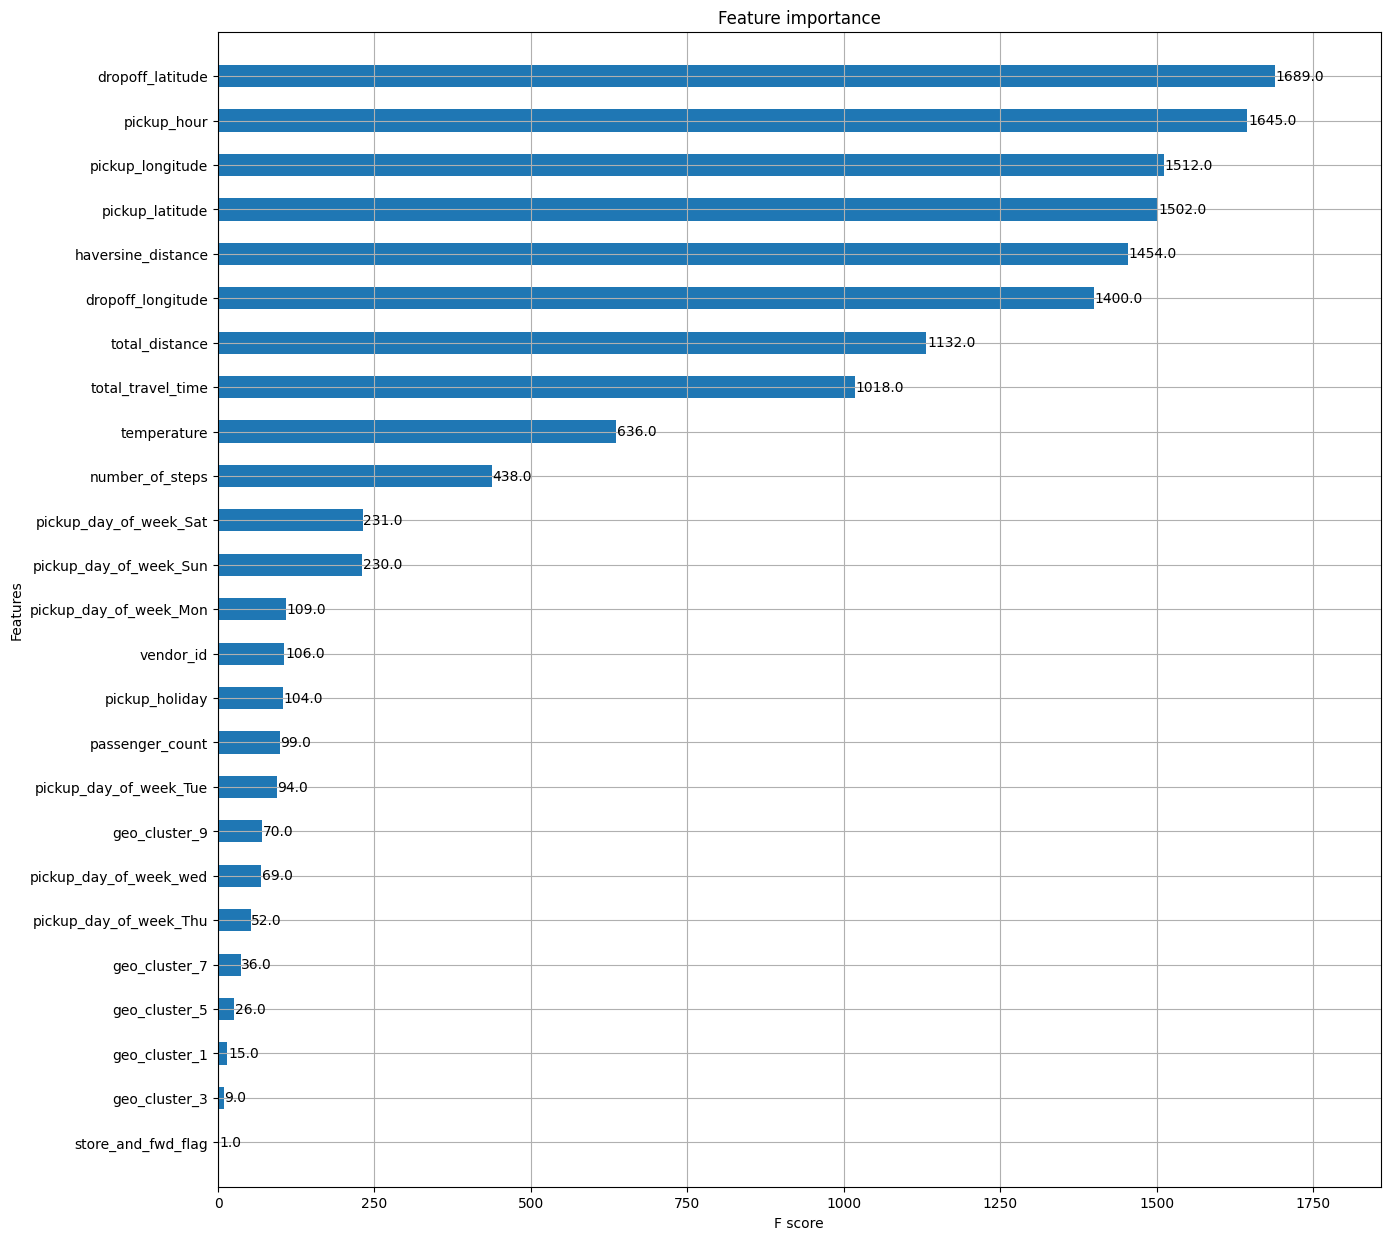

In [64]:
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(model_xgb, ax = ax, height=0.5)